In [1]:
import re
import datetime
from itertools import product
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
pd.set_option('max_colwidth', None)
pd.set_option('display.max_columns', None) 
import matplotlib.pyplot as plt 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

from utils import clean_data, preprocess, remove_url, detect_language

In [2]:
# import the dataset
BMBF = pd.read_csv("../data/cleanedBMBF.csv")
BMBF.shape

(272234, 26)

In [3]:
# import the crossref enriched dataset
crossref_enrichment = pd.read_csv("../data/BMBF_crossref_enrichment.csv")
crossref_enrichment.shape

(237, 2)

In [4]:
# check how many overlapping grant identifiers (primary keys) (169 are found) 
mask = set(crossref_enrichment["AWARD"]).intersection(set(BMBF["FKZ"]))
len(mask)

169

In [5]:
# remove records that does not have related primary keys in BMBF table
crossref_enrichment = crossref_enrichment.loc[crossref_enrichment["AWARD"].isin(list(mask)),:]
crossref_enrichment.shape

(169, 2)

In [6]:
# join 2 dataset
BMBF = pd.merge(BMBF,crossref_enrichment,left_on='FKZ', right_on='AWARD', how="outer")

In [7]:
# change data type to string
BMBF["crossref_enrichment"].replace({pd.NA: ''}, inplace=True)
BMBF["crossref_enrichment"].nunique()

168

In [8]:
# merge Thema and enriched data
BMBF["enriched_Thema"] = BMBF["Thema"] + " " + BMBF["crossref_enrichment"]

In [9]:
BMBF.loc[BMBF["FKZ"].isin(list(mask)),["crossref_enrichment","enriched_Thema"]]

,crossref_enrichment,enriched_Thema
90671,Erfassung des subjektiven körperlichen Wohlbefindens bei Herzinsuffizienz,Kompetenznetz Herzinsuffizienz Erfassung des subjektiven körperlichen Wohlbefindens bei Herzinsuffizienz
106137,Evaluation eines Interventionsansatzes zur Verbesserung von Motivation und motivationsförderlichem Unterrichtshandeln von Lehrkräften auf Basis der Zielorientierungstheorie,"Verbundvorhaben: Berufliche Zielorientierungen von Lehrkräften: Entwicklungsbedingungen, Auswirkungen auf berufliche Kompetenzentwicklung, Effekte auf instruktionales Verhalten sowie Lernprozesse und Lernergebnisse von Schülern, Teilprojekt Mannheim Evaluation eines Interventionsansatzes zur Verbesserung von Motivation und motivationsförderlichem Unterrichtshandeln von Lehrkräften auf Basis der Zielorientierungstheorie"
108617,"Kovalent‐allosterische Kinase‐Inhibitoren AbstractProteinkinasen repräsentieren wichtige Knotenpunkte intrazellulärer Signalwege und sind somit an vielen physiologischen und pathologischen Prozessen beteiligt. Konformations‐abhängige Eigenschaften dienen hierbei der Feinregulation ihrer enzymatischen Aktivität und Katalyse‐unabhängigen Funktionen. Die Stabilisierung definierter Konformationen ermöglicht detaillierte Analysen solcher Konformations‐abhängiger Funktionen. Hier beschreiben wir das strukturbasierte Design, die Synthese und die Charakterisierung Pleckstrin‐Homologie(PH)‐Domänen‐abhängiger Akt‐Inhibitoren, die einen neuartigen kovalent‐allosterischen Bindungsmodus aufweisen. Durch die kovalente Modifizierung bestimmter Cysteine stabilisieren diese Moleküle die inaktive Kinasekonformation irreversibel. Ihre beträchtliche Inhibitorwirkung und Selektivität bezüglich verwandter Proteinkinasen machen sie zu einem neuartigen Hilfsmittel für die Erforschung chemisch‐biologischer und medizinischer Fragestellungen.","Verbundprojekt: Onkogen, Anteil Technische Universität Dortmund (Teilprojekt 5 und 6b) Kovalent‐allosterische Kinase‐Inhibitoren AbstractProteinkinasen repräsentieren wichtige Knotenpunkte intrazellulärer Signalwege und sind somit an vielen physiologischen und pathologischen Prozessen beteiligt. Konformations‐abhängige Eigenschaften dienen hierbei der Feinregulation ihrer enzymatischen Aktivität und Katalyse‐unabhängigen Funktionen. Die Stabilisierung definierter Konformationen ermöglicht detaillierte Analysen solcher Konformations‐abhängiger Funktionen. Hier beschreiben wir das strukturbasierte Design, die Synthese und die Charakterisierung Pleckstrin‐Homologie(PH)‐Domänen‐abhängiger Akt‐Inhibitoren, die einen neuartigen kovalent‐allosterischen Bindungsmodus aufweisen. Durch die kovalente Modifizierung bestimmter Cysteine stabilisieren diese Moleküle die inaktive Kinasekonformation irreversibel. Ihre beträchtliche Inhibitorwirkung und Selektivität bezüglich verwandter Proteinkinasen machen sie zu einem neuartigen Hilfsmittel für die Erforschung chemisch‐biologischer und medizinischer Fragestellungen."
110811,Informelles Pflegepotenzial bei Älteren in Deutschland,"Hamburger Zentrum für Gesundheitsökonomie - Ökonomische Evaluation der Gesundheitsversorgung chronisch und psychisch Kranker: Teilprojekte TP IIA Nachwuchsgruppe Ökonomische Evaluation psychischer/ pflegeintensiver Erkrankungen, TP IIIB Bevölkerungspräferenzen für Pflege und TP IIIC Patienten Benefit Index Informelles Pflegepotenzial bei Älteren in Deutschland"
116086,"Lichtinduzierte Steuerung der Löslichkeit von Polyfluoren zur Steigerung der Leistung in OLEDs AbstractDie Prozessierung organischer Bauelemente aus der Flüssigphase ist ein wichtiger Schritt zur Entwicklung kostengünstiger Fertigungsprozesse. Wir beschreiben eine Methode zur lichtinduzierten Löslichkeitsschaltung eines π‐konjugierten Polymers (Polyfluoren), dessen Seitenketten mit Hydroxyzimtsäureester funktionalisiert sind. Die Belichtung dünner Polymerfilme führt zur Abspaltung der Seitenketten, wodurch die Löslichkeit der Filme drastisch gesenkt wird. In einer ersten

In [31]:
def calculate_scores(X_SvD,cluster_labels):
    
    print("calculate scores")
    # calculate davies bouldin score
    davies_bouldin_avg = davies_bouldin_score(X_SvD, cluster_labels)
    
    # calculate calinski harabasz score
    calinski_harabasz_avg = calinski_harabasz_score(X_SvD, cluster_labels )
    
    # calculate silhouette score
    silhouette_avg = silhouette_score(X_SvD, cluster_labels ,metric = "cosine")

 
    return davies_bouldin_avg, calinski_harabasz_avg, silhouette_avg


In [29]:
def perform_dbscan(texts, min_sample, eps, n_dim =400):
    
    print(f"set min_sample = {min_sample}, eps={eps} ") 
    print("vectorizing data...")
    # TF-IDF Vectorization
    vectorizer = TfidfVectorizer(tokenizer=preprocess)
    tfidf_matrix = vectorizer.fit_transform(texts)

    print("reducing dimensions...")
    # Dimensionality Reduction
    svd = TruncatedSVD(n_components = n_dim,random_state=42)
    X_SvD = svd.fit_transform(tfidf_matrix)

    print("clustering...")
    # DBSCAN Clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_sample,metric="cosine")
    dbscan = dbscan.fit(X_SvD)
    
    print("calculating scores...")
    # calculate scores
    cluster_labels = dbscan.labels_
    scores = calculate_scores(X_SvD,cluster_labels)
    
    
    return cluster_labels, scores


In [32]:
texts = BMBF["Thema"]
times =[]
scores = dict()
for min_sample,eps in tqdm(list(product([3,5,7],[0.3,0.5,0.7]))):
    
    start_time = datetime.datetime.now()
    
    cluster_labels,score = perform_dbscan(texts, min_sample=min_sample, eps=eps)
    BMBF[f"Thema-{min_sample}-{eps}"] = cluster_labels
    scores[f"sample={min_sample}, eps={eps}"] = score
    
    end_time = datetime.datetime.now()
    times.append(end_time-start_time)

  0%|                                                                                             | 0/9 [00:00<?, ?it/s]

set min_sample = 3, eps=0.3 
vectorizing data...
reducing dimensions...
clustering...
calculating scores...
calculate scores


 11%|█████████                                                                        | 1/9 [37:20<4:58:47, 2240.98s/it]

set min_sample = 3, eps=0.5 
vectorizing data...
reducing dimensions...
clustering...
calculating scores...
calculate scores


 22%|█████████████████▌                                                             | 2/9 [1:14:30<4:20:40, 2234.32s/it]

set min_sample = 3, eps=0.7 
vectorizing data...
reducing dimensions...
clustering...
calculating scores...
calculate scores


 33%|██████████████████████████▎                                                    | 3/9 [1:52:22<3:45:09, 2251.51s/it]

set min_sample = 5, eps=0.3 
vectorizing data...
reducing dimensions...
clustering...
calculating scores...
calculate scores


 44%|███████████████████████████████████                                            | 4/9 [2:29:29<3:06:48, 2241.68s/it]

set min_sample = 5, eps=0.5 
vectorizing data...
reducing dimensions...
clustering...
calculating scores...
calculate scores


 56%|███████████████████████████████████████████▉                                   | 5/9 [3:07:00<2:29:40, 2245.07s/it]

set min_sample = 5, eps=0.7 
vectorizing data...
reducing dimensions...
clustering...
calculating scores...
calculate scores


 67%|████████████████████████████████████████████████████▋                          | 6/9 [3:44:50<1:52:40, 2253.59s/it]

set min_sample = 7, eps=0.3 
vectorizing data...
reducing dimensions...
clustering...
calculating scores...
calculate scores


 78%|█████████████████████████████████████████████████████████████▍                 | 7/9 [4:22:19<1:15:04, 2252.01s/it]

set min_sample = 7, eps=0.5 
vectorizing data...
reducing dimensions...
clustering...
calculating scores...
calculate scores


 89%|████████████████████████████████████████████████████████████████████████         | 8/9 [4:58:15<37:01, 2221.69s/it]

set min_sample = 7, eps=0.7 
vectorizing data...
reducing dimensions...
clustering...
calculating scores...
calculate scores


100%|█████████████████████████████████████████████████████████████████████████████████| 9/9 [5:34:20<00:00, 2228.91s/it]


In [190]:
BMBF_cluster_metrics = pd.DataFrame.from_dict(scores).transpose()
BMBF_cluster_metrics.columns=["davies bouldin index","calinski harabasz index","silhouette score"]
BMBF_cluster_metrics

,davies bouldin index,calinski harabasz index,silhouette score
"sample=3, eps=0.3",3.025800,6.342986,-0.361304
"sample=3, eps=0.5",6.807038,0.468475,-0.123646
"sample=3, eps=0.7",6.826709,0.016330,0.022948
"sample=5, eps=0.3",3.378148,12.331760,-0.317897
"sample=5, eps=0.5",6.808407,1.732529,-0.086262
"sample=5, eps=0.7",6.826709,0.016330,0.022948
"sample=7, eps=0.3",3.666554,52.050395,-0.279762
"sample=7, eps=0.5",6.757567,3.870358,-0.065864
"sample=7, eps=0.7",6.826709,0.016330,0.022948


store the clustering metrics in a csv file
pd.DataFrame.from_dict(clustering_enriched_Thema_scores).transpose().to_csv("../results/Thema_scores.csv")

store the clustering results in a csv file
BMBF.loc[:,[col for col in BMBF.columns if col.startswith("Thema")]].to_csv("../results/clusters.csv",index= False)

In [60]:
texts = BMBF["enriched_Thema"]
clustering_enriched_Thema_scores = dict()
for min_sample,eps in tqdm(list(product([3,5,7],[0.3,0.5,0.7]))):

    cluster_labels,score = perform_dbscan(texts, min_sample=min_sample, eps=eps)
    BMBF[f"enriched_Thema-{min_sample}-{eps}"] = cluster_labels
    clustering_enriched_Thema_scores[f"sample={min_sample}, eps={eps}"] = score


  0%|                                                                                             | 0/9 [00:00<?, ?it/s]

set min_sample = 3, eps=0.3 
vectorizing data...
reducing dimensions...
clustering...
calculating scores...
calculate scores


 11%|████████▋                                                                     | 1/9 [1:22:41<11:01:34, 4961.80s/it]

set min_sample = 3, eps=0.5 
vectorizing data...
reducing dimensions...
clustering...
calculating scores...
calculate scores


 22%|█████████████████▌                                                             | 2/9 [2:05:45<6:55:39, 3562.76s/it]

set min_sample = 3, eps=0.7 
vectorizing data...
reducing dimensions...
clustering...
calculating scores...
calculate scores


 33%|██████████████████████████▎                                                    | 3/9 [2:50:32<5:16:19, 3163.17s/it]

set min_sample = 5, eps=0.3 
vectorizing data...
reducing dimensions...
clustering...
calculating scores...
calculate scores


 44%|███████████████████████████████████                                            | 4/9 [3:28:14<3:53:56, 2807.32s/it]

set min_sample = 5, eps=0.5 
vectorizing data...
reducing dimensions...
clustering...
calculating scores...
calculate scores


 56%|███████████████████████████████████████████▉                                   | 5/9 [4:06:37<2:55:00, 2625.22s/it]

set min_sample = 5, eps=0.7 
vectorizing data...
reducing dimensions...
clustering...
calculating scores...
calculate scores


 67%|████████████████████████████████████████████████████▋                          | 6/9 [5:12:02<2:33:22, 3067.41s/it]

set min_sample = 7, eps=0.3 
vectorizing data...
reducing dimensions...
clustering...
calculating scores...
calculate scores


 78%|█████████████████████████████████████████████████████████████▍                 | 7/9 [6:21:29<1:54:13, 3426.66s/it]

set min_sample = 7, eps=0.5 
vectorizing data...
reducing dimensions...
clustering...
calculating scores...
calculate scores


 89%|██████████████████████████████████████████████████████████████████████▏        | 8/9 [7:30:11<1:00:48, 3648.29s/it]

set min_sample = 7, eps=0.7 
vectorizing data...
reducing dimensions...
clustering...
calculating scores...
calculate scores


100%|█████████████████████████████████████████████████████████████████████████████████| 9/9 [8:36:41<00:00, 3444.56s/it]


In [206]:
BMBF_enriched_text_metrics = pd.DataFrame.from_dict(clustering_enriched_Thema_scores).transpose()
BMBF_enriched_text_metrics.columns=["davies bouldin index","calinski harabasz index","silhouette score"]
BMBF_enriched_text_metrics

,davies bouldin index,calinski harabasz index,silhouette score
"sample=3, eps=0.3",3.036091,6.294135,-0.362556
"sample=3, eps=0.5",6.812955,0.458209,-0.121560
"sample=3, eps=0.7",6.826178,0.016334,0.022944
"sample=5, eps=0.3",3.327823,12.359851,-0.320648
"sample=5, eps=0.5",6.809610,1.833141,-0.084222
"sample=5, eps=0.7",6.826178,0.016334,0.022944
"sample=7, eps=0.3",3.598422,52.537678,-0.280346
"sample=7, eps=0.5",6.765396,3.848555,-0.065733
"sample=7, eps=0.7",6.826178,0.016334,0.022944


store the clustering results in a csv file
BMBF.loc[:,[col for col in BMBF.columns if col.startswith("enriched_Thema")]].to_csv("../results/enriched_clusters.csv",index= False)

store the clustering metrics in a csv file
pd.DataFrame.from_dict(clustering_enriched_Thema_scores).transpose().to_csv("../results/enriched_Thema_scores.csv")

In [207]:
# merge the metrics to a dataframe
metrics = BMBF_cluster_metrics.join(BMBF_enriched_text_metrics,lsuffix = ' before enrichment', rsuffix=' after enrichment')

In [224]:
def plot_scores(evaluate_metric):
    
    ''' function to plot and compare the metrics before and after enrichment'''
    evaluate_metric = evaluate_metric.lower().strip()
    
    ax = metrics.loc[:,[f"{evaluate_metric} before enrichment",f"{evaluate_metric} after enrichment"]].plot(kind="barh",figsize=(10,6));
    plt.subplots_adjust(left=0.25)
   
    if evaluate_metric != "silhouette score":
        ax.legend(loc='lower right', bbox_to_anchor=(1, 0.01),fontsize='9')
        if evaluate_metric == "davies bouldin index":
            ax.legend(loc='lower right', bbox_to_anchor=(1, 0.01),fontsize='9')
            ax.set_xlim(0, 8)
        elif evaluate_metric == "calinski harabasz index":
            ax.set_xlim(0, 60)
        
        for index, value in enumerate(metrics[f"{evaluate_metric} after enrichment"]):
            ax.text(value+0.1, index+0.1, str(round(value,4)))

        for index, value in enumerate(metrics[f"{evaluate_metric} before enrichment"]):
            ax.text(value+0.1, index-0.2, str(round(value,4)))

        
    elif evaluate_metric == "silhouette score":
        
        ax.set_xlim(-0.45, 0.1)
        for index, value in enumerate(metrics[f"{evaluate_metric} after enrichment"]):
            if value > 0:
                ax.text(value+0.01, index+0.1, str(round(value,4)))
            else:
                ax.text(value-0.05, index+0.1, str(round(value,4)))

        for index, value in enumerate(metrics[f"{evaluate_metric} before enrichment"]):
            if value > 0:
                ax.text(value+0.01, index-0.2, str(round(value,4)))
            else:
                ax.text(value-0.05, index-0.2, str(round(value,4)))

  
    plt.savefig(f'../results/{evaluate_metric}.png')
    plt.show()


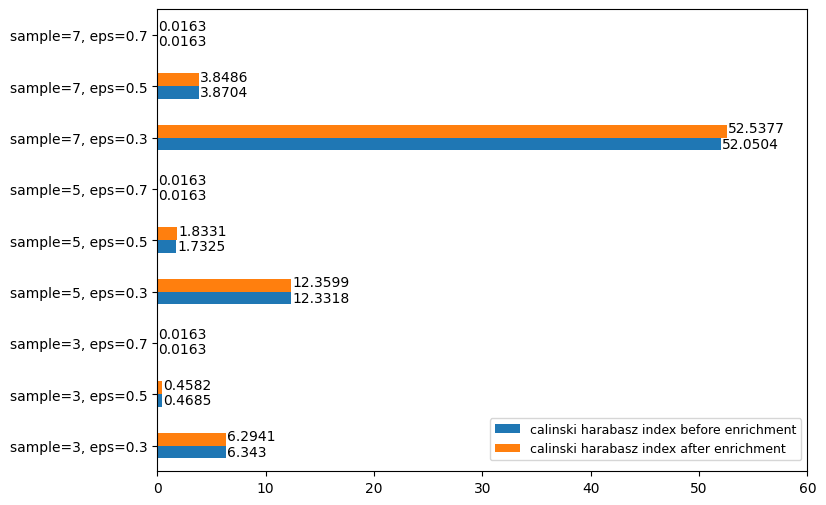

In [214]:
plot_scores("Calinski Harabasz Index")

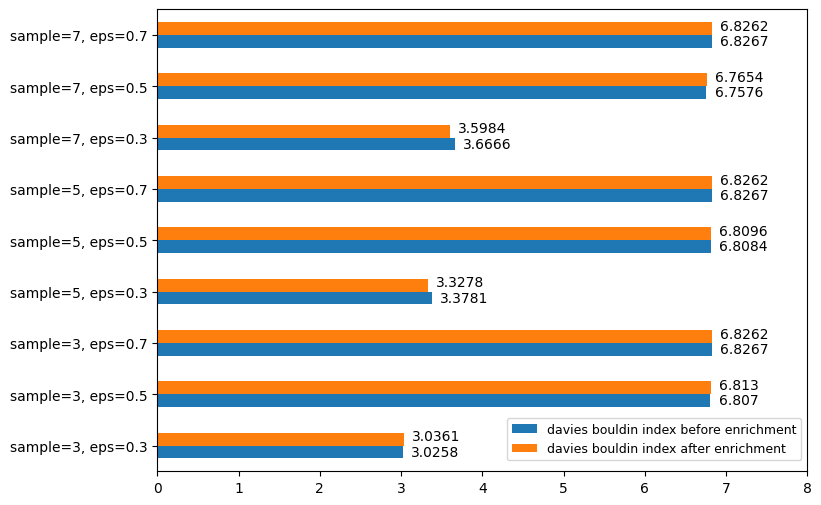

In [215]:
plot_scores("davies bouldin index")

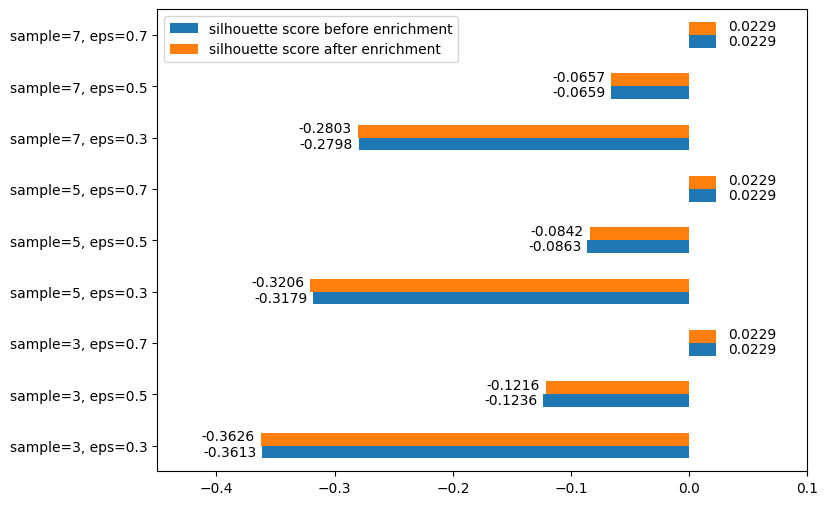

In [225]:
plot_scores("Silhouette Score")

store all the data set including cluster labels
BMBF.to_csv("../results/clustersBMBF.csv", index= False)